# Transforming pretrained 3-channel network into 4-channel in Keras

The idea is to 

1. Create a 4-channel template with consistent, TF-approved graph 
2. Load it with weights from 3-channle imagenet version
 
> _Previous attempts to directly modify layer tensors from 3 to 4 channels met severe misunderstanding from the  TF backend and led to various "inconsistent graph" errors, "I will not let you reshape the tensor embedded in the graph!" and further swearing from TF side. Hence the workaround is to load pretrained weights for each layer into variable (Numpy array type), modify array and then load it into the fresh 4-channel template._

We start with loading pretrained and template models:

In [1]:
# In this example we are using InceptionResNetV2, but it generally works with any network.

from keras.applications.inception_resnet_v2 import InceptionResNetV2

print("Loading 4-channel template with random weights . . ")

irv2_4ch = InceptionResNetV2(
        input_shape = (None,None,4),
        weights=None,
        include_top=False)

print("Loading model with 3-channel imagenet weights . . ")
# Get model with imagenet weights for further 
# implantation in 4-channel model

irv2_orig = InceptionResNetV2(
        input_shape = (None,None,3),
        weights='imagenet',
        include_top=False)

print("Loading models done . .")

Using TensorFlow backend.


Loading 4-channel template with random weights . . 


/work/modules/Ubuntu/14.04/amd64/common/anaconda3/latest/lib/python3.6/site-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


Loading model with 3-channel imagenet weights . . 
Loading models done . .


## Check which layers need modification

One can check the graph of the model to see which layers need 3-to-4 channels modification. In all the cases we encountered (VGG, InceptionResNetV2, NASNet Mobile), only the first input Conv layer required modification.

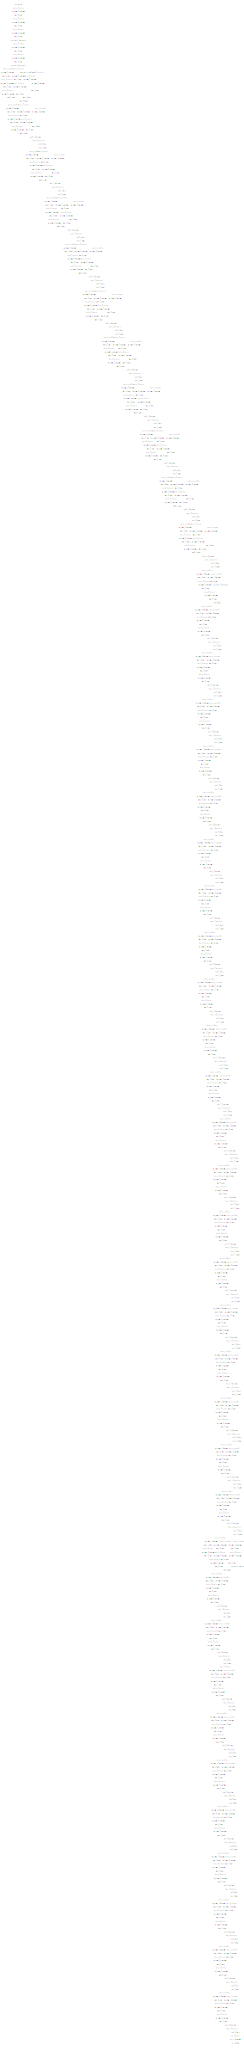

In [7]:
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot

display(SVG(model_to_dot(irv2_orig).create(prog='dot', format='svg')))

It is a bit hard to evaluate the rest of the network topology through the small Ipython window, so we exported the above SVG into a separate file (Graphs/irn2_graph.html) for fullscreen browser show.

## Layers modification

To make things a bit more OOP, we have wrapped the code to load/modify weights into a function.

In [9]:
import numpy as np

def create_4_channel_from(pretrained, template_4_ch, layers_to_modify):
    
    print("Total number of layers:", len(template_4_ch.layers))
    
    for index in range(len(template_4_ch.layers)):
    
        if template_4_ch.layers[index].get_weights() != []:
            print('non-emtpy weigths layer found:',index)
            if index in layers_to_modify:
                print("modifying layer",index)
                
                # Save weights in buffer variable
                imagenet_weigths_3ch = pretrained.layers[index].get_weights()[0]
                # This does not use bias, so only index [0] 
                # where kernels are stored is needed. 
                # Otherwise also add line for biases stored in [1]
                
                # Modify weights to have extra channel
                
                imagenet_weights_4ch = np.concatenate((imagenet_weigths_3ch,
                                                      imagenet_weigths_3ch[:,:,-1:,:]),
                                                      axis=-2) # For channels_last
                
                template_4_ch.layers[index].set_weights([imagenet_weights_4ch])
                
            else:
                template_4_ch.layers[index].set_weights(
                        pretrained.layers[index].get_weights())
    
    return template_4_ch

In [10]:
# Function works with constant indexes instead of changing names
layers_to_modify = [1] # Turns out the only layer that changes
                                    # shape due to 4th channel is the first
                                    # convolution layer.

irv2_4ch = create_4_channel_from(irv2_orig, irv2_4ch, layers_to_modify)

Total number of layers: 780
non-emtpy weigths layer found: 1
modifying layer 1
non-emtpy weigths layer found: 2
non-emtpy weigths layer found: 4
non-emtpy weigths layer found: 5
non-emtpy weigths layer found: 7
non-emtpy weigths layer found: 8
non-emtpy weigths layer found: 11
non-emtpy weigths layer found: 12
non-emtpy weigths layer found: 14
non-emtpy weigths layer found: 15
non-emtpy weigths layer found: 18
non-emtpy weigths layer found: 19
non-emtpy weigths layer found: 21
non-emtpy weigths layer found: 22
non-emtpy weigths layer found: 23
non-emtpy weigths layer found: 24
non-emtpy weigths layer found: 28
non-emtpy weigths layer found: 29
non-emtpy weigths layer found: 30
non-emtpy weigths layer found: 31
non-emtpy weigths layer found: 32
non-emtpy weigths layer found: 33
non-emtpy weigths layer found: 34
non-emtpy weigths layer found: 35
non-emtpy weigths layer found: 41
non-emtpy weigths layer found: 42
non-emtpy weigths layer found: 44
non-emtpy weigths layer found: 45
non-emtp

non-emtpy weigths layer found: 404
non-emtpy weigths layer found: 406
non-emtpy weigths layer found: 407
non-emtpy weigths layer found: 409
non-emtpy weigths layer found: 410
non-emtpy weigths layer found: 411
non-emtpy weigths layer found: 412
non-emtpy weigths layer found: 416
non-emtpy weigths layer found: 419
non-emtpy weigths layer found: 420
non-emtpy weigths layer found: 422
non-emtpy weigths layer found: 423
non-emtpy weigths layer found: 425
non-emtpy weigths layer found: 426
non-emtpy weigths layer found: 427
non-emtpy weigths layer found: 428
non-emtpy weigths layer found: 432
non-emtpy weigths layer found: 435
non-emtpy weigths layer found: 436
non-emtpy weigths layer found: 438
non-emtpy weigths layer found: 439
non-emtpy weigths layer found: 441
non-emtpy weigths layer found: 442
non-emtpy weigths layer found: 443
non-emtpy weigths layer found: 444
non-emtpy weigths layer found: 448
non-emtpy weigths layer found: 451
non-emtpy weigths layer found: 452
non-emtpy weigths la

Loading weights by layer is not the fastest way. For example, Keras backend has a function to store all weights in memory and then set them at once. However, it is a rather explicit way, which is good for debugging, and the 3-to-4 convertion operation needs to be done only few times during the project work. 

Finally, the 4-channel model with pretrained weights should be saved for future use:

In [11]:
irv2_4ch.save('InceptionResNetV2_Freeshape_4-chan_imagenet.hdf5')